# Datawhale 零基础入门数据挖掘-Task3 特征工程

## 1.特征工程目标

* 对于特征进行进一步分析，并对于数据进行处理

* 完成对于特征工程的分析，并对于数据进行一些图表或者文字总结并打卡。


特征工程的主要内容包含对于异常数据与无用特征的剔除，对特征进行构造以增强其表达能力，对标签的处理等等，总体目的在于增强特征在特定模型下的表达能力。

所以特征工程的进行一定是与后续模型紧密相关的，例如利用lightgbm训练数据的话nan值可以不用填补，而使用LR或者NN模型时，nan无法识别，字符类型的数据可能需要做one hot，或者加载预训练的词向量。

## 2.内容介绍
常见的特征工程包括：
1. 异常处理：
    - 通过箱线图删除异常值；
2. 特征归一化/标准化：
    - 归一化（抓换到 [0,1] 区间）；
3. 数据分桶：
    - 等距分桶；
4. 缺失值处理：
    - 不处理（针对类似 XGBoost 等树模型）；
    - 删除（缺失数据太多）；
    - 插值补全，包括均值/中位数/众数/建模预测/多重插补/压缩感知补全/矩阵补全等；
    - 分箱，缺失值一个箱；
5. 特征构造：
    - 构造统计量特征，报告计数、求和、比例、标准差等；
    - 时间特征，包括相对时间和绝对时间，节假日，双休日等；
    - 地理信息，包括分箱，分布编码等方法；
    - 根据特征对标签极其明显的影响选择对应方法
6. 特征筛选
    - 过滤式（filter）：先对数据进行特征选择，然后在训练学习器，常见的方法有 Relief/方差选择发/相关系数法/卡方检验法/互信息法；
    - 包裹式（wrapper）：直接把最终将要使用的学习器的性能作为特征子集的评价准则，常见方法有 LVM（Las Vegas Wrapper） ；
    - 嵌入式（embedding）：结合过滤式和包裹式，学习器训练过程中自动进行了特征选择，常见的有 lasso 回归；

## 3.代码示例

### 3.0 导入数据与工具

In [105]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from operator import itemgetter
warnings.filterwarnings('ignore')

%matplotlib inline
train = pd.read_csv('train.csv', sep=' ', header=0, index_col=0)
test = pd.read_csv('test.csv', sep=' ', header=0, index_col=0)
#加上header与index_col使数据读取过程直接使用已有数据作为index，不再自动生成新的index
pd.set_option('display.max_columns', None)#显示所有列
train['notRepairedDamage'].replace('-', np.nan, inplace=True)
test['notRepairedDamage'].replace('-', np.nan, inplace=True)
print(train.shape)
print(test.shape)

(150000, 30)
(50000, 29)


In [101]:
train.head()

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
SaleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,NaN,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


### 3.1 常用数据处理函数定义

In [83]:
#填补nan
def nanfill(data, fill_value = -1):
    data.fillna(fill_value)
    
#箱线图处理异常值,默认删除阈值为
def boxplot_del(data, columns_name, del_threshold = 0.005):
    assert del_threshold>=0 #del_threshold must be a positive number
    assert del_threshold<=0.5 #del_threshold must less than or equal to 0.5
    assert isinstance(data,pd.DataFrame) #type of data should be dataframe
    data.sort_values(columns_name, inplace = True)
    upper_value = data[columns_name].iloc[int(data.shape[0] * (1 - del_threshold))]
    downer_value = data[columns_name].iloc[int(data.shape[0] * del_threshold)]
    original_rows = data.shape[0]
    print('delete upper value:')
    print(upper_value)
    print('delete downer value:')
    print(downer_value)
    data.sort_index(inplace = True)
    data = data[data[columns_name]<=upper_value]
    data = data[data[columns_name]>=downer_value]
    print('delete rows number:')
    print(original_rows - data.shape[0])
    return data

#对单个特征做one hot
def get_columns_one_hot(data, columns_name, granularity = 1, data_type = 'int'):
    assert granularity != 0
    if int(granularity) != 0:
        granularity = int(granularity)
    zero_array = np.array([0]*data.shape[0])
    zero_array.reshape(-1,1)
    zero_array = pd.DataFrame(zero_array)
    data['temp'] = zero_array
    nan_num = data[columns_name].isnull().sum()
    if data_type == 'int':
        one_hot_list = list((data[columns_name]//granularity).unique())
    elif data_type == 'float':
        one_hot_list = list(round(data[columns_name]/granularity).unique())
    else:
        one_hot_list = list(data[columns_name].unique())
    columns_list = []
    for i in range(len(one_hot_list)):
        columns_list.append(columns_name + '_' + str(one_hot_list[i]))
        data[columns_list[i]] = zero_array.copy()
        if data_type == 'int':
            data.loc[data[columns_name]//granularity == one_hot_list[i],columns_list[i]] = 1
        elif data_type == 'float':
            data.loc[round(data[columns_name]//granularity) == one_hot_list[i],columns_list[i]] = 1
        else:
            data.loc[data[columns_name] == one_hot_list[i], columns_list[i]] = 1
        data['temp'] = data['temp'] + data[columns_list[i]]
    if nan_num:
        columns_list.append(columns_name+'_nan')
        data[columns_name+'_nan'] = zero_array.copy()
        data.loc[data[columns_name]!=data[columns_name], columns_name+'_nan'] = 1
        data['temp'] = data['temp'] + data[columns_name+'_nan']
    assert len(data['temp'].unique())==1
    assert data['temp'].unique()[0]==1
    data.drop('temp',axis=1,inplace=True)
    return data

#数据归一化
def normalize(data, columns_name):
    data_max = data[columns_name].max()
    data_min = data[columns_name].min()
    data[columns_name+'_max'] = data_max
    data[columns_name+'_min'] = data_min
    data[columns_name] = (data[columns_name] - data[columns_name+'_min'])/(data[columns_name+'_max']-data[columns_name+'_min'])
    return data

In [69]:
boxplot_del(train, 'power')

delete upper value:
400
delete downer value:
0
delete rows number:
706


,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
SaleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,NaN,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482
5,137642,20090602,24.0,10,0.0,1.0,0.0,109,10.0,0.0,3690,0,0,20160319,8000,46.323165,-3.229285,0.156615,-1.727217,-0.345690,0.260246,0.000518,0.119838,0.090922,0.048769,1.885526,-2.721943,2.457660,-0.286973,0.206573
6,2402,19990411,13.0,4,0.0,0.0,1.0,150,15.0,0.0,3073,0,0,20160317,3500,46.104335,4.926219,0.113311,1.644606,-1.270381,0.267998,0.117675,0.142334,0.025446,0.028174,-4.902200,1.610616,-0.834605,-1.996117,-0.103180
7,165346,19990706,26.0,14,1.0,0.0,0.0,101,15.0,0.0,4000,0,0,20160326,1000,42.255586,-3.167771,-0.676693,1.942673,0.524206,0.239506,0.000000,0.122943,0.039839,0.082413,3.693829,-0.245014,-2.192810,0.236728,0.195567
8,2974,20030205,19.0,1,2.0,1.0,1.0,179,15.0,0.0,4679,0,0,20160326,2850,46.084888,4.893717,0.475333,0.556575,-1.262490,0.263833,0.116583,0.144255,0.039851,0.024388,-4.925234,1.587796,0.075348,-1.551098,0.069433


### 3.1 特征构造

In [70]:
# 对训练数据与测试数据采取同样的方式构建特征
train['train']=1
test['train']=0
data = pd.concat([train, test], ignore_index=True, sort=False)

In [71]:
# 感性来说，同样一辆车从使用开始（creatDate）到售卖（regDate）时间越久，价格越低
data['used_time'] = (pd.to_datetime(data['creatDate'], format='%Y%m%d', errors='coerce') - 
                            pd.to_datetime(data['regDate'], format='%Y%m%d', errors='coerce')).dt.days

In [72]:
# 从邮编中提取城市信息，因为是德国的数据，所以参考德国的邮编，相当于加入了先验知识
data['city'] = data['regionCode'].apply(lambda x : str(x)[:-3])

In [73]:
# 计算某品牌的销售统计量
# 这里要以 train 的数据计算统计量
train_gb = train.groupby("brand")
all_info = {}
for kind, kind_data in train_gb:
    info = {}
    kind_data = kind_data[kind_data['price'] > 0]
    info['brand_amount'] = len(kind_data)
    info['brand_price_max'] = kind_data.price.max()
    info['brand_price_median'] = kind_data.price.median()
    info['brand_price_min'] = kind_data.price.min()
    info['brand_price_sum'] = kind_data.price.sum()
    info['brand_price_std'] = kind_data.price.std()
    info['brand_price_average'] = round(kind_data.price.sum() / (len(kind_data) + 1), 2)
    all_info[kind] = info
brand_fe = pd.DataFrame(all_info).T.reset_index().rename(columns={"index": "brand"})
data = data.merge(brand_fe, how='left', on='brand')

In [74]:
# 数据分桶
# 数据分桶的目的在于对在某一特征区间内的特征拥有相同特性的，放入同样的一个桶中
# 可以增强特征的训练效果
# LightGBM 在改进 XGBoost 时就增加了数据分桶，增强了模型的泛化性

bin = [i*10 for i in range(31)]
data['power_bin'] = pd.cut(data['power'], bin, labels=False)
data[['power_bin', 'power']].head()

,power_bin,power
0,5.0,60
1,NaN,0
2,16.0,163
3,19.0,193
4,6.0,68


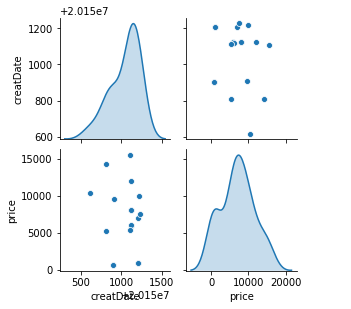

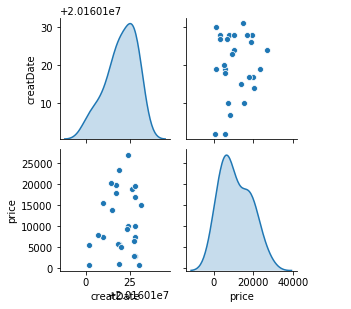

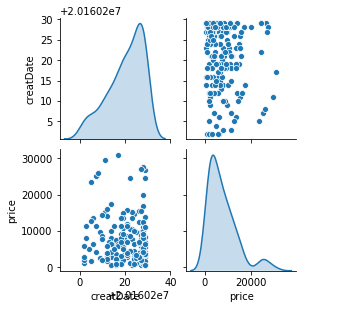

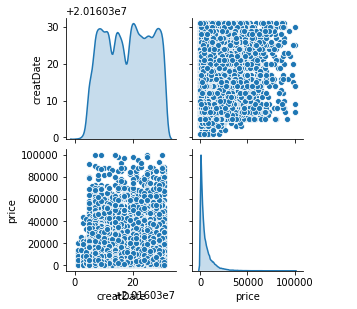

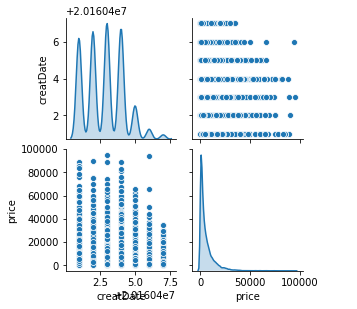

In [106]:
#creatDate数据观察
pd.set_option('display.max_columns', None)
columns = ['creatDate','price']
data2 = train[train['creatDate']<20151231]
data3 = train[train['creatDate']>=20151231]
sns.pairplot(data2[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()
data4 = train[train['creatDate']>(20151250)][train['creatDate']<=20160150]
data5 = train[train['creatDate']>(20160150)][train['creatDate']<=20160250]
data6 = train[train['creatDate']>(20160250)][train['creatDate']<=20160350]
data7 = train[train['creatDate']>(20160350)][train['creatDate']<=20160450]
sns.pairplot(data4[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()
sns.pairplot(data5[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()
sns.pairplot(data6[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()
sns.pairplot(data7[columns],size = 2 ,kind ='scatter',diag_kind='kde')
plt.show()


In [84]:
#creatDate做one hot
get_columns_one_hot(data, 'creatDate', 100);#按月做

In [77]:
#部分数据归一化
normalize(data, 'kilometer')
normalize(data, 'brand_amount')
normalize(data, 'brand_price_average')
normalize(data, 'brand_price_max')
normalize(data, 'brand_price_median')
normalize(data, 'brand_price_min')
normalize(data, 'brand_price_std')
normalize(data, 'brand_price_sum');

In [86]:
#部分数据做one_hot
get_columns_one_hot(data, 'model', data_type='int')
get_columns_one_hot(data, 'brand', data_type='int')
get_columns_one_hot(data, 'bodyType', data_type='int')
get_columns_one_hot(data, 'fuelType', data_type='int')
get_columns_one_hot(data, 'gearbox', data_type='int')
get_columns_one_hot(data, 'notRepairedDamage', data_type='other')
get_columns_one_hot(data, 'power_bin', data_type='int');

### 3.2 特征筛选

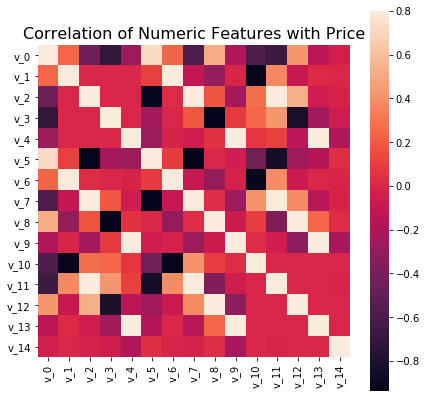

,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
v_0,1.000000,0.243649,-0.446950,-0.711896,-0.261806,0.723763,0.242587,-0.579968,0.517134,-0.190289,-0.580749,-0.665110,0.421745,-0.138920,-0.039176
v_1,0.243649,1.000000,0.001718,-0.001000,0.000256,0.106963,0.999417,-0.108640,-0.299219,-0.007473,-0.922389,0.374752,-0.086916,0.017650,0.002003
v_2,-0.446950,0.001718,1.000000,-0.001164,-0.000637,-0.920722,0.026650,0.973368,0.180722,-0.234657,0.269452,0.798663,0.534412,-0.055131,-0.015106
v_3,-0.711896,-0.001000,-0.001164,1.000000,-0.000075,-0.233157,0.000080,0.190026,-0.933538,0.081418,0.246482,0.430291,-0.813126,-0.244264,-0.057994
v_4,-0.261806,0.000256,-0.000637,-0.000075,1.000000,-0.262138,-0.010547,-0.054041,0.050023,0.963269,0.071119,0.112481,-0.135888,0.934664,-0.178421
v_5,0.723763,0.106963,-0.920722,-0.233157,-0.262138,1.000000,0.089018,-0.938518,0.012104,-0.054157,-0.437061,-0.844516,-0.255110,-0.164693,0.039222
v_6,0.242587,0.999417,0.026650,0.000080,-0.010547,0.089018,1.000000,-0.083315,-0.295166,-0.022785,-0.917629,0.390581,-0.069597,0.001071,-0.003462
v_7,-0.579968,-0.108640,0.973368,0.190026,-0.054041,-0.938518,-0.083315,1.000000,0.028294,-0.262634,0.406210,0.811067,0.383569,-0.154761,-0.021442
v_8,0.517134,-0.299219,0.180722,-0.933538,0.050023,0.012104,-0.295166,0.028294,1.000000,-0.065154,0.094348,-0.372116,0.882693,0.248651,0.029725
v_9,-0.190289,-0.007473,-0.234657,0.081418,0.963269,-0.054157,-0.022785,-0.262634,-0.065154,1.000000,0.027911,-0.052773,-0.314150,0.880927,-0.213625


In [89]:
# 相关性分析
f =[]
for i in range(15):
    f.append('v_'+str(i))
price_numeric = data[f]
correlation = price_numeric.corr()
f , ax = plt.subplots(figsize = (7, 7))
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
sns.heatmap(correlation,square = True,  vmax=0.8)
plt.show()
pd.DataFrame(correlation)

经过观察发现'v_5','v_6','v_7','v_8','v_9','v_10','v_12'特征与其他数据相关度高，可以用其他数据替代，故删去

In [94]:
del_list = ['v_5','v_6','v_7','v_8','v_9','v_10','v_12']

In [92]:
# 观察现有特征
data.head(1)

,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,train,used_time,city,brand_amount,brand_price_average,brand_price_max,brand_price_median,brand_price_min,brand_price_std,brand_price_sum,power_bin,num_date_1,num_data_2,num_data_3,creatDate_201604,creatDate_201603,creatDate_201602,creatDate_201601,creatDate_201511,creatDate_201508,creatDate_201509,creatDate_201506,creatDate_201512,kilometer_max,kilometer_min,brand_amount_max,brand_amount_min,brand_price_average_max,brand_price_average_min,brand_price_max_max,brand_price_max_min,brand_price_median_max,brand_price_median_min,brand_price_min_max,brand_price_min_min,brand_price_std_max,brand_price_std_min,brand_price_sum_max,brand_price_sum_min,model_30.0,model_40.0,model_115.0,model_109.0,model_110.0,model_24.0,model_13.0,model_26.0,model_19.0,model_7.0,model_1.0,model_48.0,model_65.0,model_138.0,model_105.0,model_114.0,model_-0.0,model_8.0,model_78.0,model_21.0,model_3.0,model_4.0,model_31.0,model_121.0,model_75.0,model_17.0,model_107.0,model_16.0,model_111.0,model_47.0,model_5.0,model_44.0,model_200.0,model_155.0,model_87.0,model_20.0,model_22.0,model_63.0,model_49.0,model_29.0,model_88.0,model_60.0,model_73.0,model_39.0,model_23.0,model_11.0,model_69.0,model_167.0,model_199.0,model_178.0,model_101.0,model_6.0,model_10.0,model_57.0,model_33.0,model_32.0,model_52.0,model_46.0,model_74.0,model_93.0,model_125.0,model_41.0,model_127.0,model_104.0,model_98.0,model_68.0,model_156.0,model_116.0,model_170.0,model_160.0,model_85.0,model_80.0,model_143.0,model_77.0,model_166.0,model_53.0,model_66.0,model_203.0,model_14.0,model_42.0,model_119.0,model_174.0,model_177.0,model_210.0,model_36.0,model_238.0,model_70.0,model_58.0,model_126.0,model_84.0,model_97.0,model_108.0,model_192.0,model_64.0,model_15.0,model_95.0,model_54.0,model_142.0,model_55.0,model_218.0,model_222.0,model_163.0,model_76.0,model_83.0,model_122.0,model_18.0,model_124.0,model_106.0,model_59.0,model_228.0,model_164.0,model_165.0,model_145.0,model_94.0,model_186.0,model_220.0,model_179.0,model_67.0,model_71.0,model_25.0,model_144.0,model_212.0,model_172.0,model_168.0,model_206.0,model_152.0,model_123.0,model_182.0,model_38.0,model_117.0,model_132.0,model_99.0,model_183.0,model_219.0,model_62.0,model_173.0,model_82.0,model_34.0,model_102.0,model_213.0,model_92.0,model_162.0,model_43.0,model_175.0,model_35.0,model_61.0,model_113.0,model_137.0,model_226.0,model_161.0,model_134.0,model_202.0,model_130.0,model_146.0,model_139.0,model_45.0,model_112.0,model_227.0,model_195.0,model_2.0,model_51.0,model_232.0,model_129.0,model_135.0,model_169.0,model_191.0,model_148.0,model_140.0,model_9.0,model_201.0,model_237.0,model_221.0,model_171.0,model_196.0,model_204.0,model_185.0,model_147.0,model_189.0,model_193.0,model_214.0,model_56.0,model_180.0,model_100.0,model_187.0,model_91.0,model_208.0,model_150.0,model_131.0,model_28.0,model_188.0,model_149.0,model_12.0,model_118.0,model_184.0,model_120.0,model_50.0,model_136.0,model_176.0,model_223.0,model_79.0,model_37.0,model_133.0,model_27.0,model_246.0,model_96.0,model_153.0,model_103.0,model_194.0,model_154.0,model_240.0,model_225.0,model_90.0,model_86.0,model_207.0,model_234.0,model_141.0,model_181.0,model_211.0,model_197.0,model_81.0,model_217.0,model_216.0,model_157.0,model_243.0,model_239.0,model_159.0,model_244.0,model_128.0,model_72.0,model_158.0,model_190.0,model_215.0,model_205.0,model_151.0,model_224.0,model_236.0,model_231.0,model_230.0,model_89.0,model_198.0,model_209.0,model_233.0,model_241.0,model_229.0,model_nan,model_235.0,model_245.0,model_242.0,model_247.0,brand_6,brand_1,brand_15,brand_10,brand_5,brand_4,brand_14,brand_7,brand_9,brand_0,brand_27,brand_21,brand_16,brand_3,brand_25,brand_13,brand_37,brand_11,brand_24,brand_19,brand_8,brand_17,brand_18,brand_33,brand_30,brand_29,brand_28,brand_20,brand_22,brand_12,brand_26,brand_38,

In [95]:
# 已使用特征删除
del_list.extend(['regDate','regionCode','creatDate','model','brand','fuelType','gearbox','power','notRepairedDamage','bodyType'])
# 观察到的无效特征删除
del_list.extend(['seller','offerType'])

In [96]:
for i in range(len(del_list)):
    data = data.drop(del_list[i],axis=1)

### 3.3 训练集与测试集分离

In [97]:
train_feature = data[data['train']==1]
test_feature = data[data['train']==0]

feature_train_file = 'myfeature_train.csv'
feature_test_file = 'myfeature_test.csv'

train_feature = train_feature.drop(['train'],axis=1)
test_feature = test_feature.drop(['train'],axis=1)

#train_feature.to_csv(file_path+feature_train_file)

test_feature = test_feature.drop(['price'],axis=1)
#test_feature.to_csv(file_path+feature_test_file)

## 4 总结

特征工程的主要目的还是在于将数据转换为能更好地表示潜在问题的特征，从而提高机器学习的性能。比如，异常值处理是为了去除噪声，填补缺失值可以加入先验知识等。

特征构造也属于特征工程的一部分，其目的是为了增强数据的表达。

主要内容包含对于异常数据与无用特征的剔除，对特征进行构造以增强其表达能力，对标签的处理等等，总体目的在于增强特征在特定模型下的表达能力。

所以特征工程的进行一定是与后续模型紧密相关的，例如利用lightgbm训练数据的话nan值可以不用填补，而使用LR或者NN模型时，nan无法识别，字符类型的数据可能需要做one hot，或者加载预训练的词向量。

总的来说特征工程我认为是由于模型直接遍历提取所有可能特征表达的计算量过大，故将一部分特征表达的提取转为有先验知识的人来做，进而提升学习效率，也更好指导模型学习到的知识，避免陷入奇怪的数值问题上。

---------------------------------------------------------------------------------------------------------------------------------------
与开源学习代码的区别：
* 特征筛选部分筛除了v系列几个特征（放入baseline之后发现会略微损失精度，大约10+评分）
* 发现creatDate除了与regDate的感性差值认识之外，按月份分离之后，与price分布情况呈现极其强的相关性